<a href="https://www.kaggle.com/code/armanaghania/insulator-segmentation-with-u-net?scriptVersionId=139815686" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install Dependencies

In [2]:
!pip install gitpython


# Import Dataset from GitHub

# Import Dependencies

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

import os
from PIL import Image, ImageDraw, ImageChops
from torch.utils.data import Dataset
import numpy as np

from glob import glob
import zipfile
import shutil

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim

from torch.utils.data import DataLoader
import torchvision

from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
import git

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Model

In [4]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

class UNET(nn.Module):
  def __init__(
      self, in_channels=3, out_channels=1, features=[64,128,256,512],
  ):

    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )

      self.ups.append(DoubleConv(feature*2, feature))

      self.bottleneck = DoubleConv(features[-1], features[-1]*2)

      self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups),2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

def test():
  x = torch.rand((3,1,161,161))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape


if __name__ == '__main__':
  test()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# Dataset

In [5]:
repository_url = "https://github.com/InsulatorData/InsulatorDataSet"
target_folder = "/kaggle/working/Insulator_dataset"
repo = git.Repo.clone_from(repository_url, target_folder)

In [6]:
class InsulatorDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir  = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace('jpg', 'xml'))
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = parse_xml_masks(mask_path, image_size)
#     mask[mask == 255.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [7]:
image_size = (1152, 864)

# Test Train Split

In [8]:
os.mkdir('/kaggle/working/Insulator_dataset/Normal_Insulators/val')
os.mkdir('/kaggle/working/Insulator_dataset/Normal_Insulators/val_masks')

for file in sorted(os.listdir('/kaggle/working/Insulator_dataset/Normal_Insulators/images'))[:100]:
    shutil.move('/kaggle/working/Insulator_dataset/Normal_Insulators/images/' + file, '/kaggle/working/Insulator_dataset/Normal_Insulators/val')

for file in sorted(os.listdir('/kaggle/working/Insulator_dataset/Normal_Insulators/labels'))[:100]:
    shutil.move('/kaggle/working/Insulator_dataset/Normal_Insulators/labels/' + file, '/kaggle/working/Insulator_dataset/Normal_Insulators/val_masks')

In [9]:
os.mkdir('/kaggle/working/Insulator_dataset/Normal_Insulators/saved_images')

# Hyperparameters


In [10]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 3
NUM_WORKERS = 1
IMAGE_HEIGHT = 576
IMAGE_WIDTH = 432
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/images'
TRAIN_MASK_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/labels'
VAL_IMG_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/val'
VAL_MASK_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/val_masks'

# Utils

In [11]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving Checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading Checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True
):
  train_ds = InsulatorDataset(
      image_dir=train_dir,
      mask_dir=train_maskdir,
      transform=train_transform,
  )

  train_loader = DataLoader(
      train_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=True,
  )

  val_ds = InsulatorDataset(
      image_dir=val_dir,
      mask_dir=val_maskdir,
      transform=val_transform,

  )

  val_loader = DataLoader(
      val_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=False,
  )

  return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
  num_correct = 0
  num_pixels = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      # dice_score += (2* (preds*y).sum()) / (
      #     (preds + y).sum() + 1e-8
      # )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )

    # print(f"Dice Score: {dice_score/len(loader)}")

    model.train()



def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    
    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
        # Convert the tensors to the appropriate data type (torch.uint8)
        preds = (preds * 255).to(torch.uint8)
        y = (y.unsqueeze(1) * 255).to(torch.uint8)
        
        # Convert tensors to numpy arrays and then save as images
        for i in range(preds.shape[0]):
            pred_img = preds[i].cpu().numpy()
            y_img = y[i].cpu().numpy()
            
            pred_path = os.path.join(folder, f"pred_{idx}_{i}.png")
            y_path = os.path.join(folder, f"{idx}_{i}.png")
            
            Image.fromarray(pred_img[0], mode='L').save(pred_path)
            Image.fromarray(y_img[0], mode='L').save(y_path)

#     model.train()
    
def parse_xml_masks(xml_path, image_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Create a new grayscale image
    mask = Image.new("L", image_size, 0)

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Make sure image_size is a tuple (height, width)
        height, width = image_size

        # Ensure that ymin, ymax, xmin, and xmax are within image bounds
#         ymin = max(0, ymin)
#         ymax = min(height, ymax)
#         xmin = max(0, xmin)
#         xmax = min(width, xmax)

        # Create a mask using ImageDraw
        draw = ImageDraw.Draw(mask)
        draw.rectangle([xmin, ymin, xmax, ymax], fill=255)

    # Convert the Image to a NumPy array
    mask_array = np.array(mask)
    mask_array[mask_array == 255] = 1.0  # Convert pixel values to 1.0

    return mask_array

# Train Model on Dataset to get a Checkpoint

In [12]:
 torch.cuda.empty_cache()

In [13]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    # check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )


        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

100%|██████████| 63/63 [00:56<00:00,  1.12it/s, loss=0.356]


=> Saving Checkpoint
Got 22435607/24883200 with acc 90.16


100%|██████████| 63/63 [00:49<00:00,  1.26it/s, loss=0.402]


=> Saving Checkpoint
Got 20836640/24883200 with acc 83.74


100%|██████████| 63/63 [00:49<00:00,  1.27it/s, loss=0.324]


=> Saving Checkpoint
Got 21292074/24883200 with acc 85.57


# Loading Checkpoint and Training Model for More Epochs

In [14]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMAGE_HEIGHT = 576
IMAGE_WIDTH = 432
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/images'
TRAIN_MASK_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/labels'
VAL_IMG_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/val'
VAL_MASK_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/val_masks'

In [15]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    # check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )


        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

=> Loading Checkpoint


100%|██████████| 63/63 [00:50<00:00,  1.24it/s, loss=0.405]


=> Saving Checkpoint
Got 21577692/24883200 with acc 86.72


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.183]


=> Saving Checkpoint
Got 22598647/24883200 with acc 90.82


100%|██████████| 63/63 [00:49<00:00,  1.26it/s, loss=0.259]


=> Saving Checkpoint
Got 22183800/24883200 with acc 89.15


100%|██████████| 63/63 [00:49<00:00,  1.26it/s, loss=0.248]


=> Saving Checkpoint
Got 22745412/24883200 with acc 91.41


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.179]


=> Saving Checkpoint
Got 22873694/24883200 with acc 91.92


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.174]


=> Saving Checkpoint
Got 22984869/24883200 with acc 92.37


100%|██████████| 63/63 [00:49<00:00,  1.26it/s, loss=0.188]


=> Saving Checkpoint
Got 22241931/24883200 with acc 89.39


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.223]


=> Saving Checkpoint
Got 22933073/24883200 with acc 92.16


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.187]


=> Saving Checkpoint
Got 22957533/24883200 with acc 92.26


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.191]


=> Saving Checkpoint
Got 23087186/24883200 with acc 92.78


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.156]


=> Saving Checkpoint
Got 23118259/24883200 with acc 92.91


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.128]


=> Saving Checkpoint
Got 23122132/24883200 with acc 92.92


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.188]


=> Saving Checkpoint
Got 23017340/24883200 with acc 92.50


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.157]


=> Saving Checkpoint
Got 23095824/24883200 with acc 92.82


100%|██████████| 63/63 [00:49<00:00,  1.26it/s, loss=0.117]


=> Saving Checkpoint
Got 23176309/24883200 with acc 93.14


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.14]


=> Saving Checkpoint
Got 23279065/24883200 with acc 93.55


100%|██████████| 63/63 [00:49<00:00,  1.26it/s, loss=0.114]


=> Saving Checkpoint
Got 23178383/24883200 with acc 93.15


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.246]


=> Saving Checkpoint
Got 23170488/24883200 with acc 93.12


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.164]


=> Saving Checkpoint
Got 23168853/24883200 with acc 93.11


100%|██████████| 63/63 [00:50<00:00,  1.26it/s, loss=0.254]


=> Saving Checkpoint
Got 23157135/24883200 with acc 93.06


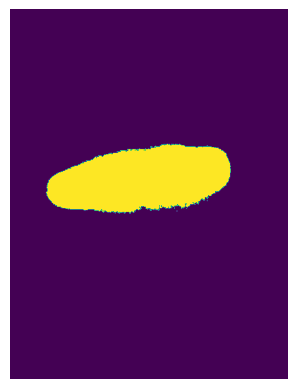

In [16]:
image = Image.open('/kaggle/working/saved_images/pred_0_4.png')
plt.imshow(image)
plt.axis("off")  # Turn off axis labels and ticks
plt.show()

# Loading Model to Evaluate

In [17]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)  # Replace with your model initialization
model.load_state_dict(torch.load("my_checkpoint.pth.tar")["state_dict"])
model.eval()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

# Testing Model on Unseen Data by the Model

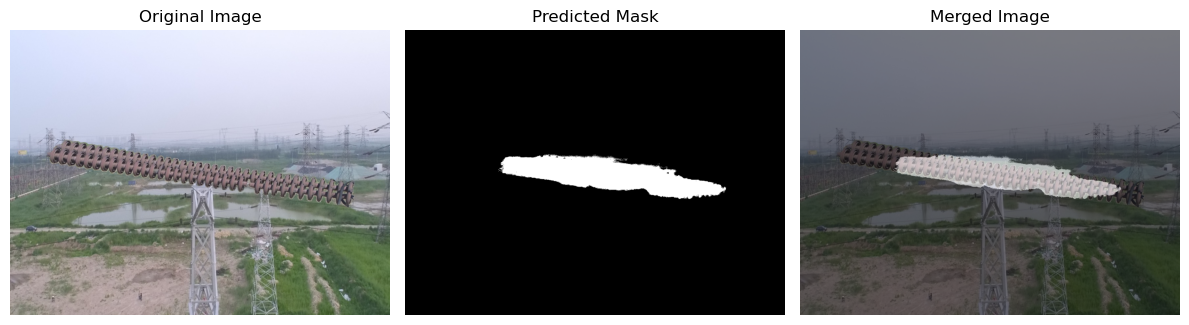

In [18]:
# Load and preprocess the new image
new_image_path = "/kaggle/working/Insulator_dataset/Defective_Insulators/images/199.jpg"  # Update the path
new_image = Image.open(new_image_path)
transform = transforms.Compose([
#     transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
])
new_image_tensor = transform(new_image).unsqueeze(0).to(DEVICE)

# Make predictions
with torch.no_grad():
    preds = model(new_image_tensor)
    preds = torch.sigmoid(preds)
    binary_preds = (preds > 0.5).float()

# Convert the tensor predictions to a NumPy array
binary_preds_np = binary_preds.squeeze().cpu().numpy()

# Display the original image and the predicted mask

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.array(new_image))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(binary_preds_np, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

# Merged Image with Mask
plt.subplot(1, 3, 3)
plt.imshow(np.array(new_image))
plt.imshow(binary_preds_np, cmap="gray", alpha=0.5)  # Adjust alpha value as needed
plt.title("Merged Image")
plt.axis("off")


plt.tight_layout()
plt.show()